# 卷积神经网络的可视化

 
 * 可视化卷积神经网络的中间输出（中间激活）

 * 可视化卷积神经网络的过滤器

 * 可视化图像中类激活的热力图

## 可视化中间激活

  展示各个卷积层和池化层输出的特征图，激活函数的输出。可以看到各个不同的过滤器。深度（通道）会被压缩到一个二维平面上。 

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 64)        0  

接下来需要一个非训练的图像：

In [2]:
img_path = '/Users/haoxingxiao/academic/data/dogs-vs-cats/small/test/cats/cat.1701.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


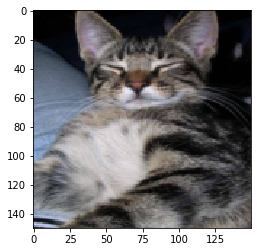

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

In [5]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


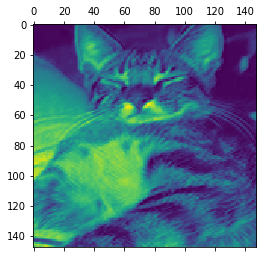

In [6]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

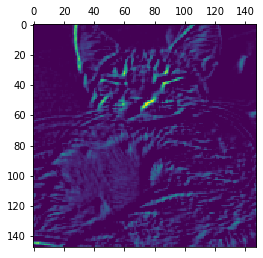

In [7]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

下面展示所有的激活：

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


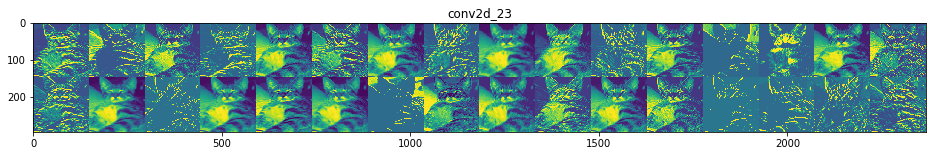

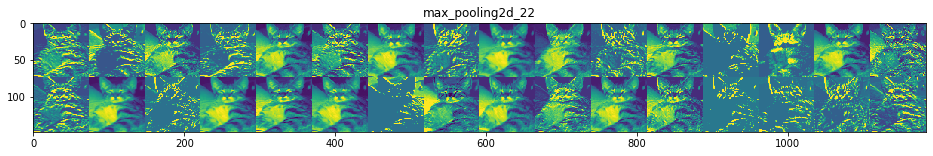

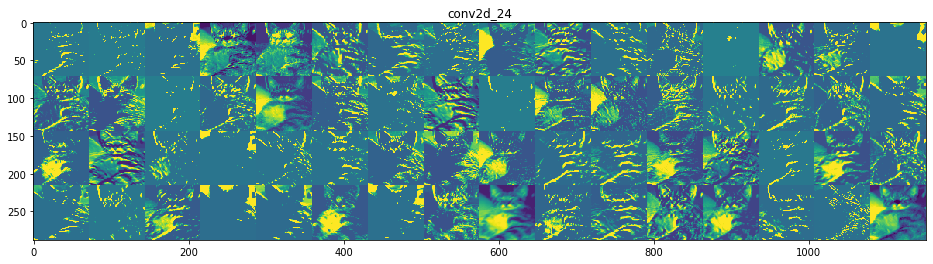

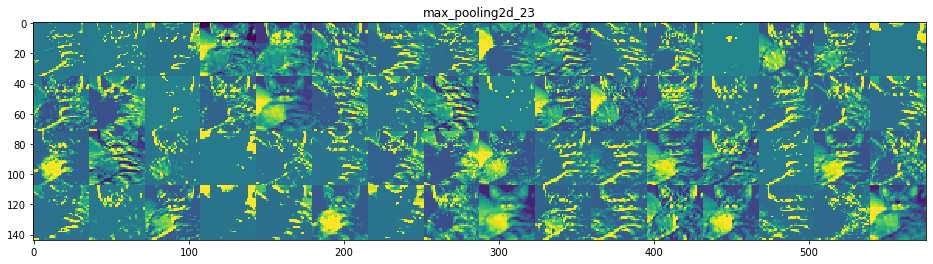

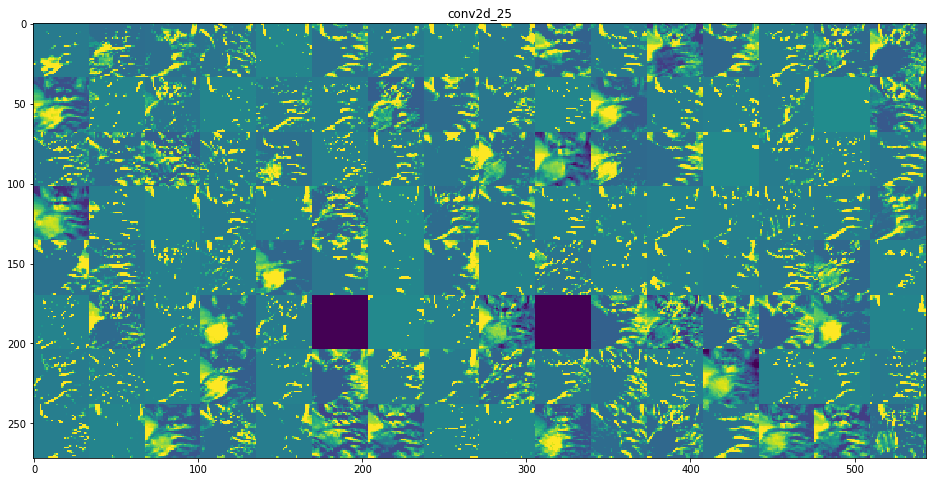

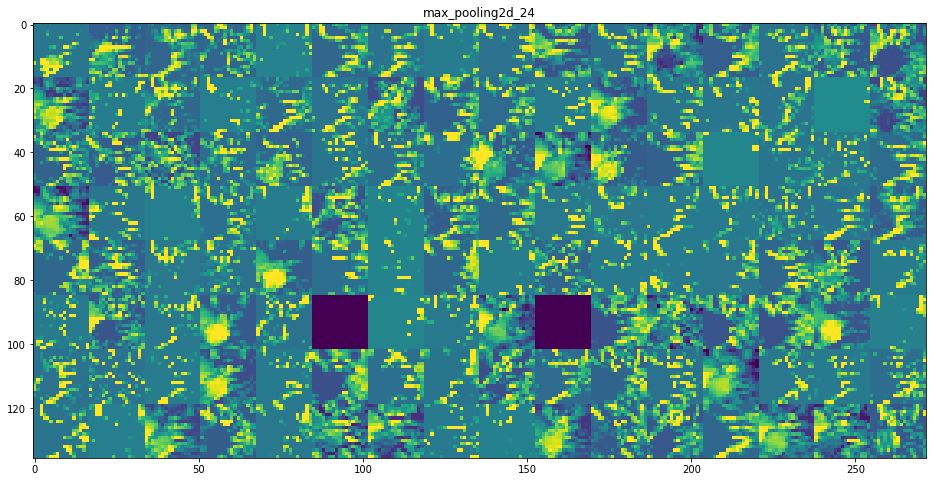

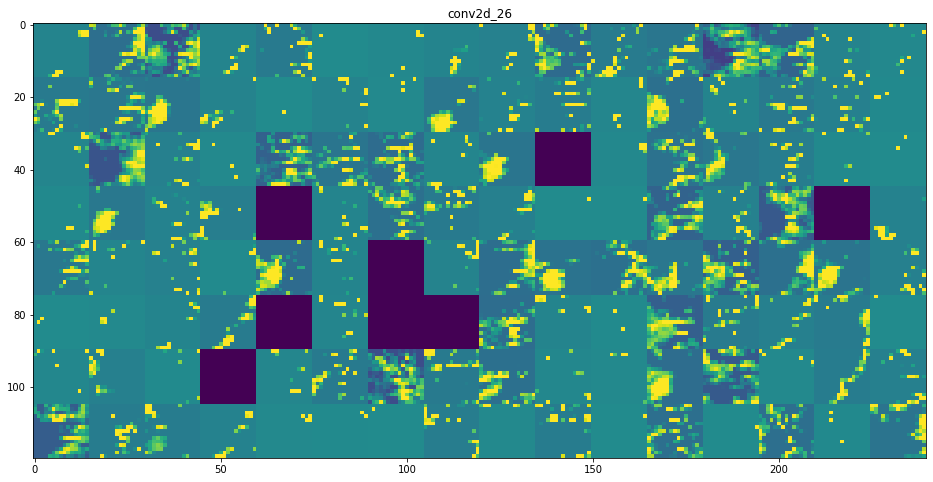

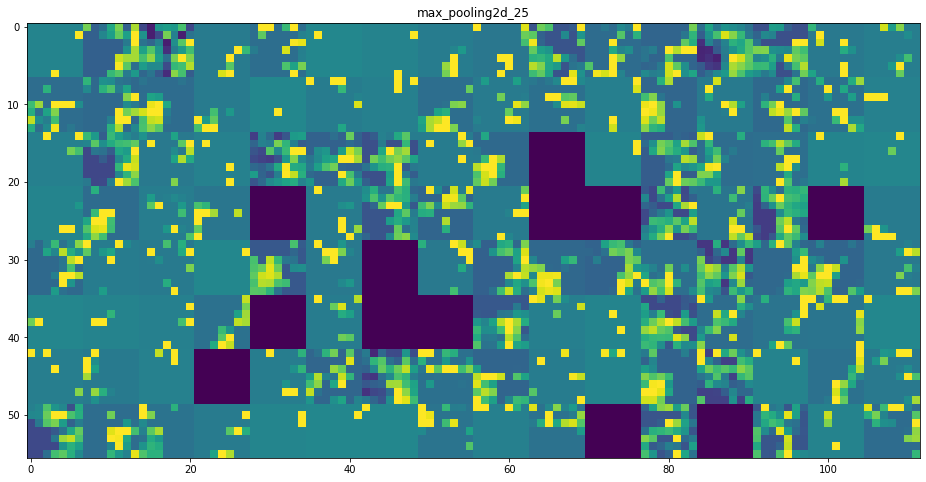

In [9]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range (n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


随着层次的加深，激活函数越来越抽象，接收的特征信息也越来越接近于目标。

## 可视化过滤器

直接显示过滤器不够直接，换种方式：显示过滤器响应的最佳的视觉模式。
在输入空间内梯度上升：从空白的输入图像开始，梯度下降应用到输入的图像中，目的是为了让某个过滤器的响应最大化。

In [10]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

# 为过滤器的可视化定义损失张量
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# 获取损失相对于输入的梯度
grads = K.gradients(loss, model.input)[0]

# 梯度标准化的技巧：加上一个非常小的变量，防止除以0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# 将张量转换为2个张量的列表：损失值和梯度值
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# 通过随机梯度下降让损失最小化，用一张随机噪点灰度图像开始（每个像素的RGB值在[108，148]之间）
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    
# 转换后的张量转换为可视范围内的图像
def deprocess_image(x):
    # 均值化，均值=0，标准差=0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x * 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 生成过滤器的可视化
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

尝试调用下函数：

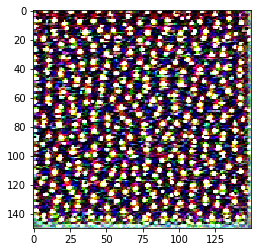

In [11]:
plt.imshow(generate_pattern('block3_conv1', 0))

下面将各个卷积层的过滤器都可视化，显示在图像中

In [ ]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

### 解释：
卷积层的每一层都有一组过滤器，可以将输入转换为过滤器的组合：**类似于傅里叶变换**。
最底层的过滤器像是过滤边缘和颜色，第二层的过滤器过滤边缘和颜色的组合成的纹理，高层的过滤器过滤更像自然界存在的纹理：羽毛，眼睛，树叶等。

## 类激活的可视化
有助于判断神经网络是根据图像的哪一部分做出的分类。

使用的方法：`Grad-CAM:visual explanatinos from deep networks via gradient-based localization`,使用2个权重：输入图像对不同的通道的激活强度+每个通道对不同类别的重要程度，推算出输入图像对类别的激活程度。

In [15]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

### 使用VGG16模型预处理图像

In [21]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/Users/haoxingxiao/Desktop/elephent.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
# 执行预测
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])